Reminder: set your runtime hardware to use GPU so that it doesn't take too long to run the models

#Pre-run (imports and datasets)

###Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from keras import metrics

np.random.seed(42)
tf.random.set_seed(42)

###dataset loading

In [ ]:
C10D = {0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [ ]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.cifar10.load_data()
xtrain = xtrain/255
xtest = xtest/255

170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
#Load adv dataset

#load from my drive
# xadv = np.load(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Generated Datasets/x10000adv.npy")/255
# yadv = np.load(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Generated Datasets/y10000adv.npy")

#load from Gitlab:
import urllib.request
urlpath = 'https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/FGSM_evasion_attack/Y2023/Key_Models_And_Datasets/'

filename = 'x10000adv.npy'
urllib.request.urlretrieve(urlpath+filename, filename)
xadv = np.load(filename)/255

filename = 'y10000adv.npy'
urllib.request.urlretrieve(urlpath+filename, filename)
yadv = np.load(filename)

##FGSM functions

In [ ]:
#This method is the backbone of all of the examples. It is all that you essentially need to do FGSM for classifications.
def FGSM(model, input, target, eps=.01):
  input = tf.cast(input, tf.float32) #The gradient tape methods used in the function require the data to be in a tf dataset
  loss_object = tf.keras.losses.CategoricalCrossentropy()
  with tf.GradientTape() as tape:
    tape.watch(input)
    prediction = model(input)
    loss = -loss_object(target, prediction)
  gradient = tape.gradient(loss, input) #This is the key line that generated the gradients
  signed_grad = tf.sign(gradient)
  return (signed_grad*eps).numpy()

In [ ]:
#this function is nessecary because FGSM needs a specific format for the target label
def giveLabel(label, total): 
  labelx = tf.one_hot(label,total)
  return tf.reshape(labelx, (1,total))

In [ ]:
def Iterate(func,model,input,target,eps,steps): 
  temp = input
  for x in range(steps):
    noise = func(model, temp, target, eps/steps)
    temp = np.clip(temp+noise, 0, 1)
  return temp

In [ ]:
#this function essentially just does the same as the last one, but it does it for each of the possible classifications.
#It then stores each of the adversaries it creates, and also formats the output in a nice way.
def getTable(stepfunc,func,model,input,labelFunc,eps,steps):
  advlist = []
  df = pd.DataFrame(columns=range(10))
  for x in range(10):
    advlist.append(stepfunc(func, model, input, labelFunc(x,10), eps, steps))
    predictions = (model.predict(advlist[x],verbose = 0).round(3))[0]
    df.loc[x] = predictions.tolist()
  return advlist, df

##Display Functions

In [ ]:
def displayPrediction(model, image, target, truelabel):
#  image = np.clip(image,0,255)
  prediction = np.argmax(model.predict(image,verbose = 0))
  # print(f"{target}")
  plt.suptitle(f"Adversary towards {target} ({C10D[ytest[target][0]]})")
  plt.title(f"Prediction: {prediction} ({C10D[prediction]}), {round(model.predict(image,verbose = 0)[0][prediction]*100,2)}%")
  # print(f"{(image[0]*255).astype(int)}")
  plt.imshow(((image[0]*255).astype(int)))
  plt.show()
  return

In [ ]:
def displayAdv(model, image, target, index):
  prediction = model.predict(image,verbose = 0)
  predlabel = np.argmax(prediction)
  plt.suptitle(f"Adversary towards {target} ({C10D[target]})")
  plt.title(f"Prediction: {predlabel} ({C10D[predlabel]}), {round(np.max(prediction)*100,2)}%")
  plt.imshow(((image[0])))
  plt.show()
  return

In [ ]:
def displayOriginal(model, image, index):
  prediction = np.argmax(model.predict(image,verbose = 0))
  plt.suptitle(f"Original Image: {ytest[index][0]} ({C10D[ytest[index][0]]})")
  plt.title(f"Prediction: {prediction} ({C10D[prediction]}), {round(model.predict(image,verbose = 0)[0][prediction]*100,2)}%")
  plt.imshow(np.clip(image[0],0,1))
  plt.show()

In [ ]:
def compareAdv(model, clean, adv, index):
  cleanprediction = model.predict(clean,verbose = 0)
  cleanpnum = np.argmax(cleanprediction)
  advprediction = model.predict(adv,verbose = 0)
  advpnum = np.argmax(advprediction)
  plt.suptitle("Clean Image")
  plt.title(f"Original Label: {ytest[index]} ({C10D[ytest[index][0]]}), Prediction: {cleanpnum} ({C10D[cleanpnum]}), {round(np.max(cleanprediction)*100,2)}%")
  plt.imshow(clean[0])
  plt.show()
  plt.suptitle("Adv Image")
  plt.title(f"Target Label: {yadv[index][1]} ({C10D[yadv[index][1]]}), Prediction: {advpnum} ({C10D[advpnum]}), {round(np.max(advprediction)*100,2)}%")
  plt.imshow(adv[0])
  plt.show()

#Basic FGSM Demo (using 32x32 CIFAR10 classifier)

In [ ]:
# classifier = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model2N.h5")
# classifierUN = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10BestModel36.h5") #uses un-normalized data
filename = 'CIFAR10Model2N.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifier = tf.keras.models.load_model(filename)

filename = 'CIFAR10Model36.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifierUN = tf.keras.models.load_model(filename)

##FGSM Creation

In [ ]:
MODEL = classifier
INDEX = 4   #any number from 0 to 5000
EPS = .02  #any number from 0 to 1
TARGET = 9   #any integer from 0 to 9, what label you are perturbing the image towards
STEPS = 10  #any integer from 1 to 100 (bigger will take longer)

#don't edit this part
input = tf.cast(np.expand_dims(xtest[INDEX],0), tf.float32)
adv = Iterate(FGSM,MODEL,input,giveLabel(TARGET,10),EPS, STEPS)
print("Done! Run the next cell to see results!")

Done! Run the next cell to see results!


Index 4, Max Epsilon: 0.02, Original Label: 6 (frog), Target Label: 9 (truck)
Original image prediction: 6 with 63.93 certainty
Adv image prediction: 9 with 76.85 certainty


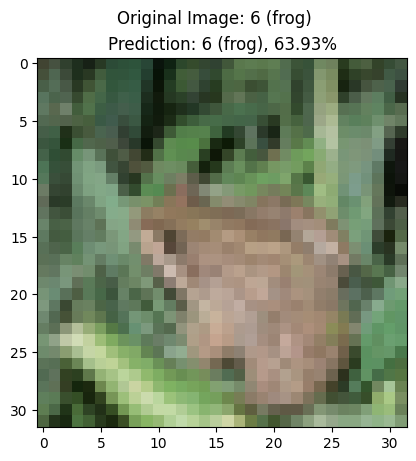

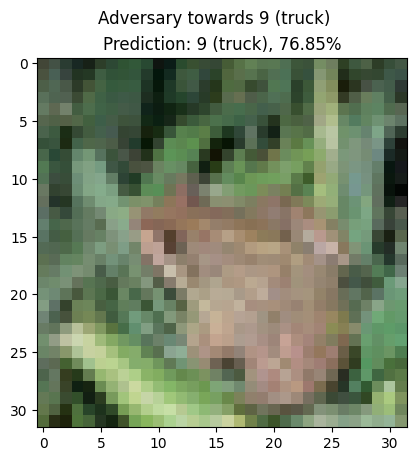

In [ ]:
print(f"Index {INDEX}, Max Epsilon: {EPS}, Original Label: {ytest[INDEX][0]} ({C10D[ytest[INDEX][0]]}), Target Label: {TARGET} ({C10D[TARGET]})")
print(f"Original image prediction: {np.argmax(MODEL.predict(input,verbose = 0))} with {round(MODEL.predict(input,verbose = 0)[0][np.argmax(MODEL.predict(input,verbose = 0))]*100,2)} certainty")
print(f"Adv image prediction: {np.argmax(MODEL.predict(adv,verbose = 0))} with {round(MODEL.predict(adv,verbose = 0)[0][np.argmax(MODEL.predict(adv,verbose = 0))]*100,2)} certainty")
displayOriginal(MODEL, input, INDEX)
# displayPrediction(MODEL, adv, INDEX, TARGET)
displayAdv(MODEL, adv, TARGET, INDEX)

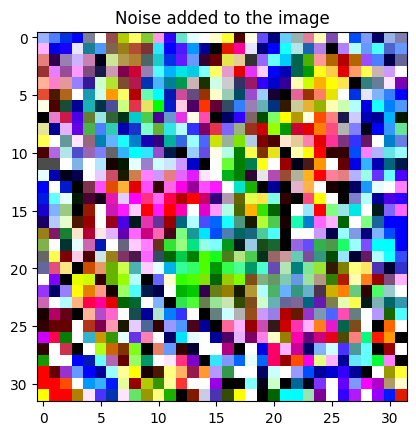

In [ ]:
noise = adv[0] - input[0]
plt.imshow(np.clip((noise + .02)*25,0,1))
plt.title(f"Noise added to the image")
plt.show()

##Datasets

For this project, something I did was creating an adversarial FGSM dataset of 10,000 images, based off of the 10,000 images in the xtest dataset. This section is mainly here to allow you to look at the adv images compared to the regular images

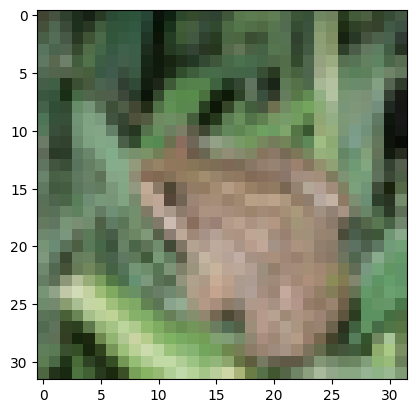

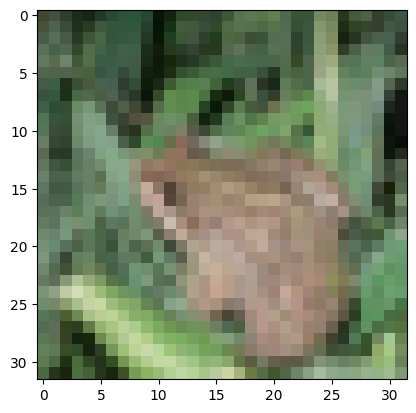

In [ ]:
#print any image from either dataset
plt.imshow(xtest[4])
plt.show()
plt.imshow(xadv[4])#from my pregenerated adv dataset
plt.show()

##Model Evaluation

This section is here to show off how the models do evaluated on the regular and adversarial datasets

In [ ]:
classifier.evaluate(xtest, ytest)
classifier.evaluate(xadv, ytest); #prevent colab from printing the results of the last line

313/313 [==============================] - 4s 12ms/step - loss: 0.9627 - accuracy: 0.6833


In [ ]:
classifierUN.evaluate(xtest*255, ytest)
classifierUN.evaluate(xadv*255, ytest);

313/313 [==============================] - 4s 13ms/step - loss: 4.1319 - accuracy: 0.2130


##Table of FGSM creation & evaluation

In [ ]:
###Copied
#warning, this will take 10x as long as the last one (since it is generating 10 images)
#Feel free to edit these values
%%time
MODEL = classifier
INDEX = 4   #any number from 0 to 5000
EPS = .01   #any number from 0 to 1
STEPS = 6  #any integer from 1 to 100 (bigger will take longer)


#don't edit this
input = tf.cast(np.expand_dims(xtest[INDEX],0), tf.float32)
advlist, table = getTable(Iterate,FGSM,MODEL,input,giveLabel,EPS,STEPS)
print("Done! Run the next cell to see results!")

Done! Run the next cell to see results!


In [ ]:
###Copied
#This table generates an adversary for each possible lable, as shown on the left-most column.
#The rows are each a set of predictions, with the leftmost column displaying what the target was for that prediction
#This means the diagonal from top left to bottom right is how well the adversary worked to perturb towards the target
print(f"        Index {INDEX}, Max Epsilon: {EPS}, Original Label: {ytest[INDEX][0]} ({C10D[ytest[INDEX][0]]})\n")
print(table)

        Index 4, Max Epsilon: 0.01, Original Label: 6 (frog)

       0      1      2      3      4      5      6      7      8      9
0  0.541  0.001  0.208  0.042  0.051  0.001  0.143  0.001  0.009  0.002
1  0.015  0.051  0.200  0.016  0.184  0.001  0.505  0.000  0.022  0.006
2  0.000  0.000  0.995  0.001  0.001  0.000  0.003  0.000  0.000  0.000
3  0.000  0.000  0.038  0.895  0.022  0.003  0.040  0.000  0.001  0.000
4  0.000  0.000  0.003  0.002  0.990  0.000  0.005  0.000  0.000  0.000
5  0.002  0.000  0.242  0.517  0.084  0.027  0.126  0.000  0.001  0.000
6  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000
7  0.021  0.002  0.312  0.223  0.243  0.008  0.170  0.006  0.013  0.002
8  0.006  0.001  0.045  0.071  0.022  0.001  0.378  0.000  0.474  0.001
9  0.142  0.013  0.225  0.049  0.083  0.001  0.436  0.001  0.018  0.030


In [ ]:
print(C10D)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


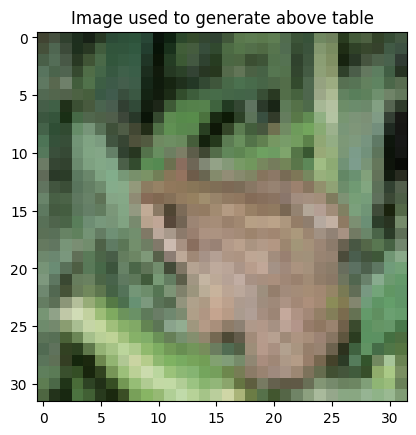

In [ ]:
plt.imshow(input[0])
plt.title(f"Image used to generate above table")
plt.show()

##Work done for presentation, can ignore this section

In [ ]:
###Copied from another notebook, still need to edit
#Feel free to edit these values
MODEL = classifier
INDEX = 4   #any number from 0 to 5000
EPS = .02  #any number from 0 to 1
TARGET = 9   #any integer from 0 to 9, what label you are perturbing the image towards
STEPS = 10  #any integer from 1 to 100 (bigger will take longer)

#don't edit this part
input = tf.cast(np.expand_dims(xtest[INDEX],0), tf.float32)
adv = Iterate(FGSM,MODEL,input,giveLabel(TARGET,10),EPS, STEPS)
print("Done! Run the next cell to see results!")

Done! Run the next cell to see results!


Index 4, Max Epsilon: 0.02, Original Label: 6 (frog), Target Label: 9 (truck)
Original image prediction: 6 with 63.93 certainty
Adv image prediction: 9 with 76.85 certainty


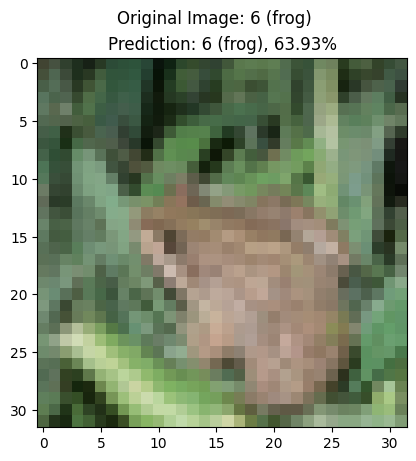

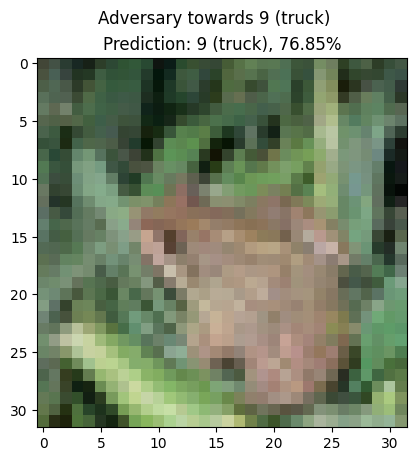

In [ ]:
###Also copied:
#comment out display lines that you don't want to see
print(f"Index {INDEX}, Max Epsilon: {EPS}, Original Label: {ytest[INDEX][0]} ({C10D[ytest[INDEX][0]]}), Target Label: {TARGET} ({C10D[TARGET]})")
print(f"Original image prediction: {np.argmax(MODEL.predict(input,verbose = 0))} with {round(MODEL.predict(input,verbose = 0)[0][np.argmax(MODEL.predict(input,verbose = 0))]*100,2)} certainty")
print(f"Adv image prediction: {np.argmax(MODEL.predict(adv,verbose = 0))} with {round(MODEL.predict(adv,verbose = 0)[0][np.argmax(MODEL.predict(adv,verbose = 0))]*100,2)} certainty")
displayOriginal(MODEL, input, INDEX)
# displayPrediction(MODEL, adv, INDEX, TARGET)
displayAdv(MODEL, adv, TARGET, INDEX)

In [ ]:
print(input[0][0][0])
print(adv[0][0][0])
print((input[0][0][0] - adv[0][0][0])*100)

tf.Tensor([0.25490198 0.26666668 0.19607843], shape=(3,), dtype=float32)
[0.25890198 0.2746667  0.21607848]
tf.Tensor([-0.4000008 -0.8000016 -2.000004 ], shape=(3,), dtype=float32)


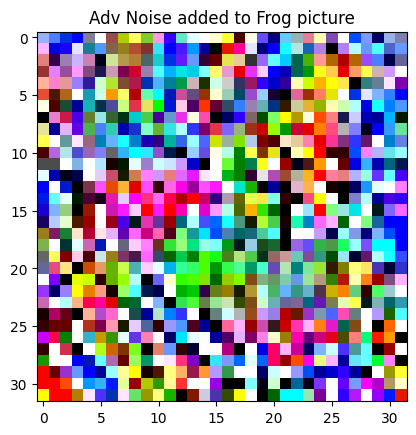

In [ ]:
plt.imshow((adv[0] - input[0]+.02)*25)
plt.title(f"Adv Noise added to Frog picture")
plt.show()

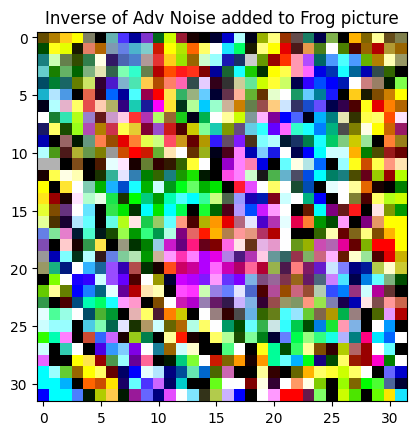

In [ ]:
plt.imshow((input[0] - adv[0] +.02)*25)
plt.title(f"Inverse of Adv Noise added to Frog picture")
plt.show()

In [ ]:
noise = (adv[0] - input[0])
advtest = input[0] + noise
adv2 = input[0] + noise*5
print(adv[0][0][0])
print(advtest[0][0])

[0.25890198 0.2746667  0.21607848]
tf.Tensor([0.25890198 0.2746667  0.21607848], shape=(3,), dtype=float32)


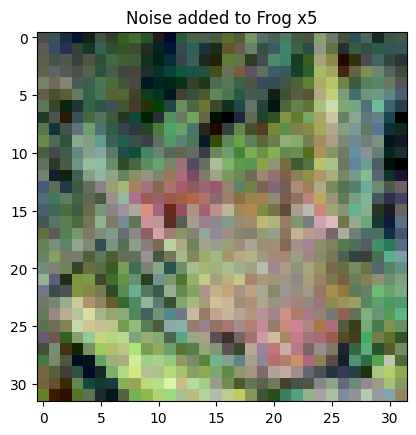

In [ ]:
plt.imshow(np.clip(adv2,0,1))
plt.title(f"Noise added to Frog x5")
plt.show()

In [ ]:
np.max((input[0] - adv[0]+.02)*25)

1.000001

In [ ]:
np.min((input[0] - adv[0]+.02)*25)

-1.0244548e-06

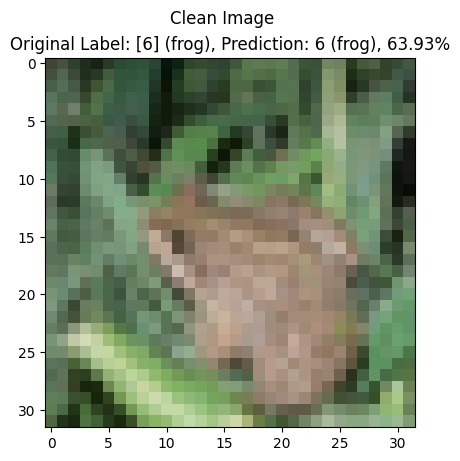

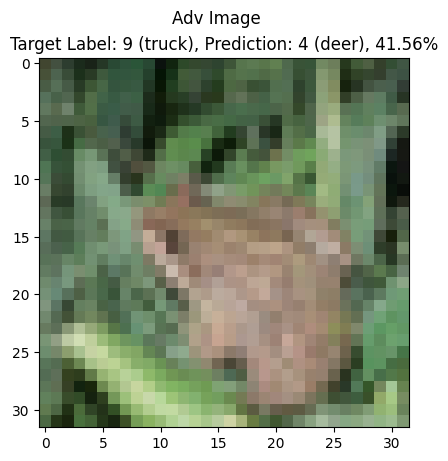

In [ ]:
compareAdv(classifier, xtest[4:5], xadv[4:5],4)

#Adv Dataset Creation
This section just shows off the code I used to create and save my dataset

If you want to use this code yourself, you can remove the comments en-mass using the keyboard shortcut "ctrl + /", which will toggle the comment for all of the selected lines of code

In [ ]:
# classifier = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model2N.h5")
## classifierUN = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10BestModel36.h5") #uses un-normalized data
filename = 'CIFAR10Model2N.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifier = tf.keras.models.load_model(filename)

In [ ]:
MODEL = classifier
EPS = .01   #any number from 0 to 1
STEPS = 6  #any integer from 1 to 100 (bigger will take longer)
SIZE = 1000
NAME = "AdvDatasetExample"
filepath = "/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/New Datasets"

In [ ]:
#If you want to use this code yourself, you can remove the comments en-mass using the
#keyboard shortcut "ctrl + /", which will toggle the comment for all of the selected lines of code

# %%time
# x = np.empty((SIZE,32,32,3), dtype=np.float32)
# y = np.empty((SIZE,2), dtype=np.int8) #np.float32, np.int8
# for j in range(SIZE):
#   INDEX = j
#   CorrectLabel = ytest[INDEX][0]
#   TARGET = random.randrange(9)   #any integer from 0 to 8, what label you are perturbing the image towards
#   if (TARGET == CorrectLabel): TARGET = 9 #This ensures the adv target is different from the original label
#   input = tf.cast(np.expand_dims(xtest[INDEX],0), tf.float32)
#   adv = Iterate(FGSM,MODEL,input,giveLabel(TARGET,10),EPS, STEPS) #generates the adv image
#   y[INDEX] = (CorrectLabel, TARGET)
#   x[INDEX] = adv
#   if j%100==0:print(f"Finished with {j} images!") #helps to keep track of how far along you are, since it takes a LONG time

In [ ]:
#save
# np.save(f"{filepath}/x{NAME}.npy", x)
# np.save(f"{filepath}/y{NAME}.npy", y)

In [ ]:
#load
# NAME = "comboadv1000v2"
# xadvR = np.load(f"{filepath}/x{NAME}.npy")
# yadvR = np.load(f"{filepath}/y{NAME}.npy")

In [ ]:
#evaluation
# print("Regular Classifier vs original dataset")
# MODEL.evaluate(xtest[:SIZE],ytest[:SIZE])
# print("Regular Classifier vs new adv")
# MODEL.evaluate(xadvR,ytest[:SIZE])
# print("Regular Classifier vs new adv (towards target label)")
# MODEL.evaluate(xadvR,yadvR[:SIZE,1])

#NN detection Demo

In [ ]:
# NNdetectorUN = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/Detection NN Models/DetectionModel10.h5") #uses un-normalized data
# classifier = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model2N.h5")
# classifierUN = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10BestModel36.h5") #uses un-normalized data

filename = 'DetectionModel10.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
NNdetectorUN = tf.keras.models.load_model(filename)

filename = 'CIFAR10Model2N.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifier = tf.keras.models.load_model(filename)

filename = 'CIFAR10Model36.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifierUN = tf.keras.models.load_model(filename)

In [ ]:
combinedx = np.concatenate((xtrain[-10000:], xadv))
print(combinedx.shape)
isadvy = np.concatenate((np.zeros(10000),np.ones(10000))) #0 means non-adv, 1 means adv
print(isadvy.shape)

(20000, 32, 32, 3)
(20000,)


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html
#import sklearn
x, y = sklearn.utils.shuffle(combinedx, isadvy)
xtrain2, xval2, xtest2 = x[:16000], x[16000:18000], x[18000:]
ytrain2, yval2, ytest2 = y[:16000], y[16000:18000], y[18000:]

Model eval on mixed dataset


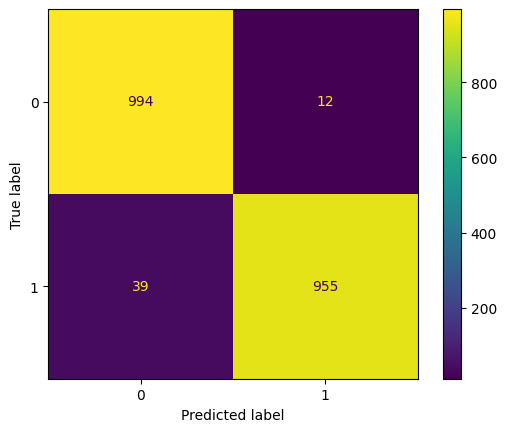

In [ ]:
print("Model eval on mixed dataset")
predictions = NNdetectorUN.predict(xtest2*255, verbose = 0)
cm = sklearn.metrics.confusion_matrix(ytest2, predictions.round())
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

#Autoenc detection Demo

In [ ]:
# autoenc = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/Detection Autoencoders/Autoencoder2-9.h5")
# classifier = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model2N.h5")
# classifierUN = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10BestModel36.h5") #uses un-normalized data

filename = 'Autoencoder2-9.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
autoenc = tf.keras.models.load_model(filename)

filename = 'CIFAR10Model2N.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifier = tf.keras.models.load_model(filename)

filename = 'CIFAR10Model36.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifierUN = tf.keras.models.load_model(filename)

###Classifier comparison on unnormalized data/models

In [ ]:
classmodel = classifierUN

In [ ]:
prednorm = autoenc.predict(xtest,verbose = 0)
predadv = autoenc.predict(xadv,verbose = 0)

In [ ]:
#Probably remove the *255 here since I created the normalized model
print("Classification model xtest:")
classmodel.evaluate(xtest*255, ytest)
print("Classification model xtest reconstructed:")
classmodel.evaluate(prednorm*255, ytest)
print("Classification model xadv:")
classmodel.evaluate(xadv*255, ytest)
print("Classification model xadv reconstructed:")
classmodel.evaluate(predadv*255, ytest); None

Classification model xtest:
313/313 [==============================] - 6s 13ms/step - loss: 0.4313 - accuracy: 0.8572
Classification model xtest reconstructed:
313/313 [==============================] - 5s 15ms/step - loss: 1.0446 - accuracy: 0.6636
Classification model xadv:
313/313 [==============================] - 4s 13ms/step - loss: 4.1319 - accuracy: 0.2130
Classification model xadv reconstructed:
313/313 [==============================] - 4s 14ms/step - loss: 1.1762 - accuracy: 0.6227


In [ ]:
sklearn.metrics.mean_squared_error(classmodel.predict(xadv[0:1]*255,verbose = 0), classmodel.predict(xtest[0:1]*255,verbose = 0))

0.1570331

In [ ]:
normerror = np.sqrt(((classmodel.predict(xtest*255,verbose = 0) - classmodel.predict(prednorm*255,verbose = 0)) ** 2).mean(axis = 1))
adverror = np.sqrt(((classmodel.predict(xadv*255,verbose = 0) - classmodel.predict(predadv*255,verbose = 0)) ** 2).mean(axis = 1))

In [ ]:
normerror_df = pd.DataFrame({'Reconstruction_error': normerror})
normerror_df["Adv"] = np.zeros(10000, dtype=int)

In [ ]:
adverror_df = pd.DataFrame({'Reconstruction_error': adverror})
adverror_df["Adv"] = np.ones(10000, dtype=int)

In [ ]:
error_df = pd.concat((normerror_df,adverror_df), ignore_index=True)
error_df.shape

(20000, 2)

In [ ]:
threshold = np.mean(normerror) + np.std(normerror)
print(threshold)

0.23761564


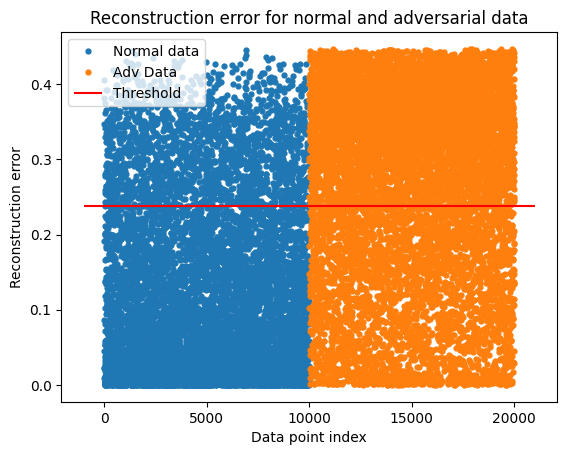

In [ ]:
groups = error_df.groupby('Adv')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Adv Data" if name == 1 else "Normal data")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and adversarial data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshpred = [1 if x > threshold else 0 for x in error_df.Reconstruction_error.values]
len(threshpred)

20000

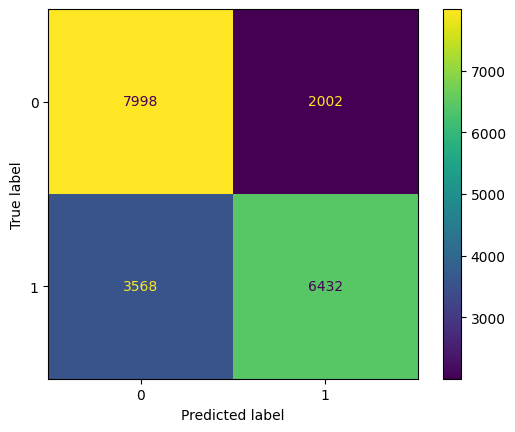

In [ ]:
cm =sklearn.metrics.confusion_matrix(error_df["Adv"], threshpred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

###Classifier comparison on normalized data (wasn't as effective since I did the original creation & testing on the non-normalized models)

In [ ]:
prednorm = autoenc.predict(xtest, verbose = 0)
predadv = autoenc.predict(xadv, verbose = 0)

In [ ]:
print("Classification model xtest:")
classifier.evaluate(xtest, ytest)
print("Classification model xtest reconstructed:")
classifier.evaluate(prednorm, ytest)
print("Classification model xadv:")
classifier.evaluate(xadv, ytest)
print("Classification model xadv reconstructed:")
classifier.evaluate(predadv, ytest)

Classification model xtest:
313/313 [==============================] - 9s 21ms/step - loss: 0.4594 - accuracy: 0.8492
Classification model xtest reconstructed:
313/313 [==============================] - 6s 18ms/step - loss: 1.1246 - accuracy: 0.6464
Classification model xadv:
313/313 [==============================] - 5s 16ms/step - loss: 0.9627 - accuracy: 0.6833
Classification model xadv reconstructed:
313/313 [==============================] - 4s 13ms/step - loss: 1.1934 - accuracy: 0.6255


[1.1933999061584473, 0.6255000233650208]

In [ ]:
sklearn.metrics.mean_squared_error(classifier.predict(xadv[0:1],verbose = 0), classifier.predict(xtest[0:1],verbose = 0)) #check that it's working for one image

0.0010738318

In [ ]:
normerror = np.sqrt(((classifier.predict(xtest,verbose = 0) - classifier.predict(prednorm,verbose = 0)) ** 2).mean(axis = 1))
adverror = np.sqrt(((classifier.predict(xadv,verbose = 0) - classifier.predict(predadv,verbose = 0)) ** 2).mean(axis = 1))

In [ ]:
normerror_df = pd.DataFrame({'Reconstruction_error': normerror})
normerror_df["Adv"] = np.zeros(10000, dtype=int)

In [ ]:
adverror_df = pd.DataFrame({'Reconstruction_error': adverror})
adverror_df["Adv"] = np.ones(10000, dtype=int)

In [ ]:
error_df = pd.concat((normerror_df,adverror_df), ignore_index=True)
error_df.shape

(20000, 2)

In [ ]:
threshold = np.mean(normerror) + np.std(normerror)
print(threshold)

0.2398308


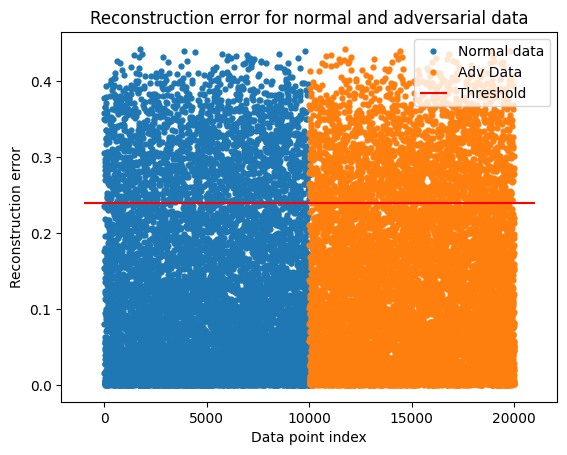

In [ ]:
groups = error_df.groupby('Adv')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Adv Data" if name == 1 else "Normal data")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and adversarial data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshpred = [1 if x > threshold else 0 for x in error_df.Reconstruction_error.values]
len(threshpred)

20000

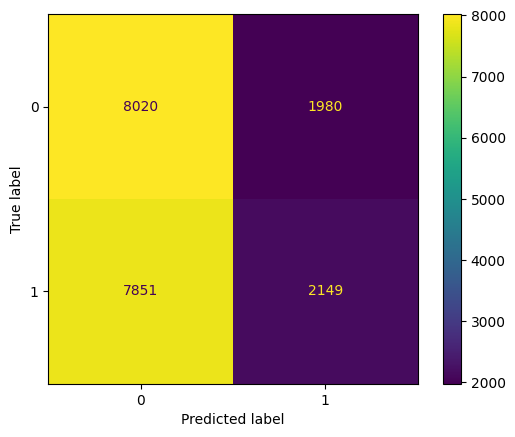

In [ ]:
cm = sklearn.metrics.confusion_matrix(error_df["Adv"], threshpred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

###Reconst error
This is the more classical way of filtering noise using autoencoders, which didn't end up being effective for the FGSM attack. I included the work here anyways in case you ended up needing/wanting to look at it.

In [ ]:
prednorm = autoenc.predict(xtest, verbose = 0)
predadv = autoenc.predict(xadv, verbose = 0)

In [ ]:
mseadv = np.mean(np.power(xadv - predadv, 2), axis = (1,2,3))
msenorm = np.mean(np.power(xtest - prednorm, 2), axis = (1,2,3))
error = np.append(mseadv,msenorm)

In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': error})
trueclass = np.append(np.ones(10000, dtype=int), np.zeros(10000, dtype=int))
error_df['True_Class'] = trueclass

In [ ]:
groups = error_df.groupby('True_Class')

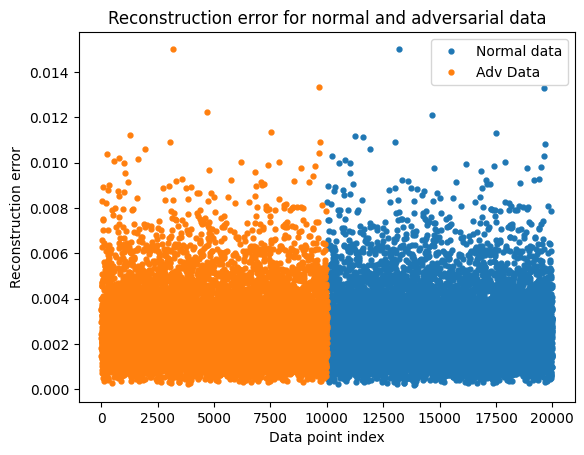

In [ ]:
#Visualize Reconstruction Error (copied)
#threshold_fixed = .01555 #REALLY low unless data is scaled properly! 
groups = error_df.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Adv Data" if name == 1 else "Normal data")
#ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and adversarial data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
autoenc.evaluate(xtest, xtest)

313/313 [==============================] - 1s 3ms/step - loss: 0.5547 - mean_absolute_error: 0.0358


[0.5547410845756531, 0.035813674330711365]

In [ ]:
autoenc.evaluate(xadv,xadv)

313/313 [==============================] - 1s 4ms/step - loss: 0.5551 - mean_absolute_error: 0.0363


[0.5551067590713501, 0.03632378205657005]

In [ ]:
print("Autoencoder model on xtest")
print(autoenc.evaluate(xtest, xtest))
print("Autoencoder model on xadv")
print(autoenc.evaluate(xadv, xadv))

Autoencoder model on xtest
313/313 [==============================] - 1s 3ms/step - loss: 0.5547 - mean_absolute_error: 0.0358
[0.5547410845756531, 0.035813674330711365]
Autoencoder model on xadv
313/313 [==============================] - 1s 3ms/step - loss: 0.5551 - mean_absolute_error: 0.0363
[0.5551067590713501, 0.03632378205657005]


#Combo Model Demo
This part of my reserach hasn't quite panned out yet. The original idea was to combine an autoencoder directly with the classifier model and then use that to genereate the FGSM attack images. The goal would be to bypass the autoencoder while still having the attack remain effective. As you will see from the code itself, the adv images generated this way are effective against the autoencoder + classifier pair, but they lose most of their effectiveness against the classifier by itself (not passing the images through the autoencoder first)

A potential solution to this is to do a combined/weighted FGSM attack using both the combined and plain classifier, assign a weight to each version of the adv, and then add them together in the iterative FGSM function. However, I haven't gotten around to testing that yet.

In [ ]:
# combo = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/Misc Models/CombinedModel.h5")
# classifier = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model2N.h5")
# classifierUN = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10BestModel36.h5") #uses un-normalized data

filename = 'CombinedModel.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
combo = tf.keras.models.load_model(filename)

filename = 'CIFAR10Model2N.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifier = tf.keras.models.load_model(filename)

filename = 'CIFAR10Model36.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifierUN = tf.keras.models.load_model(filename)

In [ ]:
# NAME = "comboadv1000v2"
# filepath = "/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/New Datasets"
# xadvcombo =  np.load(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/New Datasets/x{NAME}.npy") #created using unnormalized data
# yadvcombo = np.load(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/New Datasets/y{NAME}.npy")

filename = 'xcomboadv1000v2.npy'
urllib.request.urlretrieve(urlpath+filename, filename)
xadvcombo = np.load(filename)

filename = 'ycomboadv1000v2.npy'
urllib.request.urlretrieve(urlpath+filename, filename)
yadvcombo = np.load(filename)

In [ ]:
# print("Combined model vs xtest")
# print(combMR.evaluate(xtest,ytest, verbose = 0))
# print("Plain classifer vs xtest")

# print("Combined model vs xadv")
# print(combMR.evaluate(xadv,ytest, verbose = 0))
# print("Plain classifier vs xadv")

In [ ]:
print("Regular Classifier vs regular data")
classifierUN.evaluate(xtest[:1000]*255,ytest[:1000])
print("Combo Classifier vs regular data")
combo.evaluate(xtest[:1000]*255,ytest[:1000]) #because this dataset was created using the unnormalized data, we have to use the unnormalized model to evaluate it
print("Regular Classifier vs new adv data")
classifierUN.evaluate(xadvcombo*255,yadvcombo[:1000,0]) 
print("Combo Classifier vs new adv data")
combo.evaluate(xadvcombo*255,yadvcombo[:1000,0])

print("\nRegular Classifier vs new adv (towards target label)")
classifierUN.evaluate(xadvcombo*255,yadvcombo[:1000,1])
print("Combo Classifier vs new adv (towards target label)")
combo.evaluate(xadvcombo*255,yadvcombo[:1000,1])

Regular Classifier vs regular data
32/32 [==============================] - 4s 31ms/step - loss: 0.4233 - accuracy: 0.8520
Combo Classifier vs regular data
32/32 [==============================] - 3s 18ms/step - loss: 3.9565 - accuracy: 0.1140
Regular Classifier vs new adv data
32/32 [==============================] - 2s 14ms/step - loss: 0.4893 - accuracy: 0.8300
Combo Classifier vs new adv data
32/32 [==============================] - 2s 15ms/step - loss: 3.9565 - accuracy: 0.1130

Regular Classifier vs new adv (towards target label)
32/32 [==============================] - 0s 12ms/step - loss: 7.1732 - accuracy: 0.0450
Combo Classifier vs new adv (towards target label)
32/32 [==============================] - 0s 12ms/step - loss: 3.8469 - accuracy: 0.1070


[3.8469362258911133, 0.10700000077486038]

#Model Creation demos
This block will serve to show you the code of how I created the models I've used. I don't recommend running this code in this notebook though.

###1. CIFAR10 Classification Model using transfer learning

####Un-normalized

In [ ]:
keras.backend.clear_session()
i = 36

base_model = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    #input_tensor=None,
    input_shape=(32,32,3),
    #pooling="Avg",
    #classes=10,
    #classifier_activation="softmax",
    include_preprocessing=False,
)
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
#dropout = keras.layers.Dropout(0.05)(global_avg) 
batchnorm = keras.layers.BatchNormalization()(global_avg)
#dense1 = keras.layers.Dense(500)(batchnorm)
#dense2 = keras.layers.Dense(500)(dense1)
#dense3 = keras.layers.Dense(500)(dense2)
output = keras.layers.Dense(10, activation="softmax")(batchnorm)
Final_Model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

Final_Model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history2 = Final_Model.fit(x_train, y_train, 
                    epochs=100, validation_data=(x_test, y_test), 
                    callbacks=[stop_early1])

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

Final_Model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(5e-4), # need smaller lr
                metrics=["accuracy"])

history2 = Final_Model.fit(x_train, y_train,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[stop_early2])

In [ ]:
Final_Model.save(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10Model{i}.h5")
Final_Model_R = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10Model{i}.h5")
Final_Model.evaluate(x_test, y_test)
Final_Model_R.evaluate(x_test, y_test);

####Normalized data (model should be the same iirc)

In [ ]:
keras.backend.clear_session()
i = 2

base_model = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    #input_tensor=None,
    input_shape=(32,32,3),
    #pooling="Avg",
    #classes=10,
    #classifier_activation="softmax",
    include_preprocessing=False,
)

global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
batchnorm = keras.layers.BatchNormalization()(global_avg)
output = keras.layers.Dense(10, activation="softmax")(batchnorm)
Final_Model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

Final_Model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history2 = Final_Model.fit(xtrain, ytrain, 
                    epochs=100, validation_data=(xval, yval), 
                    callbacks=[stop_early1])

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

Final_Model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(5e-4), # need smaller lr
                metrics=["accuracy"])

history2 = Final_Model.fit(xtrain, ytrain,
                    epochs=100,
                    validation_data=(xval, yval),
                    callbacks=[stop_early2])

In [ ]:
Final_Model.save(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model{i}N.h5")
Final_Model_R = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model{i}N.h5")
Final_Model.evaluate(xtest, ytest)
Final_Model_R.evaluate(xtest, ytest)

###2. Neural Network detection model

In [ ]:
stop_early1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
stop_early2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
keras.backend.clear_session()
i = 9

base_model = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    #input_tensor=None,
    input_shape=(32,32,3),
    #pooling="Avg",
    #classes=10,
    #classifier_activation="softmax",
    include_preprocessing=False,
)
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
batchnorm = keras.layers.BatchNormalization()(global_avg)
# dense1 = keras.layers.Dense(10, activation = "selu")(batchnorm)
output = keras.layers.Dense(1, activation="sigmoid")(batchnorm)
Final_Model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

Final_Model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy", metrics.mae, metrics.categorical_accuracy])

history2 = Final_Model.fit(xtrain2, ytrain2, 
                    epochs=100, validation_data=(xval2, yval2), 
                    callbacks=[stop_early1])

In [ ]:
# Unfreeze transferered layers and finish training
%%time
for layer in base_model.layers:
    layer.trainable = True

Final_Model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Nadam(5e-4), # need smaller lr
                metrics=["accuracy", keras.metrics.mae, metrics.categorical_accuracy])

history2 = Final_Model.fit(xtrain2, ytrain2,
                    epochs=100,
                    validation_data=(xval2, yval2),
                    callbacks=[stop_early2])

In [ ]:
#saving model to drive so that I can access it later
Final_Model.save(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/Detection NN Models/DetectionModel{i}.h5")

In [ ]:
#confirming that the model saved/loaded correctly
Final_Model_R = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/Detection NN Models/DetectionModel{i}.h5")

In [ ]:
print(Final_Model.evaluate(xtest2, ytest2))
print(Final_Model_R.evaluate(xtest2, ytest2))

###3. Autoencoder model

In [ ]:
%time
keras.backend.clear_session()
t = 2
i = 9
stop_early1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
stop_early2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# from keras.datasets import cifar10
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

# Define the input shape
input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy',metrics=[metrics.mae])

# Train the model
history = autoencoder.fit(xtrain2, xtrain2, epochs=100, batch_size=16, validation_data=(xval2, xval2), callbacks=[stop_early2])

In [ ]:
autoencoder.save(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/Detection Autoencoders/Autoencoder{t}-{i}.h5")
autoencoderR = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Spring 2023/Detection Autoencoders/Autoencoder{t}-{i}.h5")
print(autoencoder.evaluate(xtest2, xtest2))
print(autoencoderR.evaluate(xtest2, xtest2))

###4. Combo model

This section documents how I combined the models through keras, which I feel would be useful to show off. I don't recommend you run this section of code, as this is mainly for reference if you ever try something similar

####Method 1: renaming layers of a clone

In [ ]:
from keras.models import Model

# Create a clone of the autoencoder model with unique names for its layers
autoenc_clone = Model.from_config(autoenc.get_config())
for layer in autoenc_clone.layers:
    layer._name = layer.name + '_autoenc'
autoenc_clone._name = "AutoEncoder_Model"
# Create a clone of the classifier model with unique names for its layers
classifier_clone = Model.from_config(classifier.get_config())
for layer in classifier_clone.layers:
    layer._name = layer.name + '_classifier'

# Connect the models
autoenc_output = autoenc_clone(input_tensor_autoenc)
classifier_output = classifier_clone(autoenc_output)
classifier_with_autoenc = Model(inputs=input_tensor_autoenc, outputs=classifier_output, name='classifier_with_autoenc')

# Compile the model
classifier_with_autoenc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
classifier_with_autoenc.summary()

Model: "classifier_with_autoenc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoenc_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 AutoEncoder_Model (Function  (None, 32, 32, 3)        13939     
 al)                                                             
                                                                 
 model (Functional)          (None, 10)                6949054   
                                                                 
Total params: 6,962,993
Trainable params: 6,889,361
Non-trainable params: 73,632
_________________________________________________________________


####Method 2: Added lambda layer to multiply the output of the autoencoder by 255, as the classifier I used at that point was unnormalized

In [ ]:
from keras.layers import Lambda, Multiply

# Define scaling layer
scaling_layer = Lambda(lambda x: x * 255., name='scaling_layer')

# Connect scaling layer to autoenc output
scaled_output = scaling_layer(autoenc.output)

# Connect scaled output to classifier input
combined_output = classifier(scaled_output)

# Create new combined model
combined_model = Model(inputs=autoenc.input, outputs=combined_output)

# Compile the combined model
combined_model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])


In [ ]:
combined_model.summary()